In [89]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.nn import Module, Sequential
from torch.nn import Linear, ReLU, Sigmoid, LeakyReLU
from torch.optim import Adam
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [91]:
file_path_train="../20240312_Deep_Learning/NN_Regression/Google_Stock_Price/Google_Stock_Price_Train.csv"
file_path_test="../20240312_Deep_Learning/NN_Regression/Google_Stock_Price/Google_Stock_Price_Test.csv"

In [92]:
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

In [93]:
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [94]:
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%m/%d/%Y')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%m/%d/%Y')

In [95]:
df_train['Volume'] = df_train['Volume'].str.replace(',', '').astype(int)
df_test['Volume'] = df_test['Volume'].str.replace(',', '').astype(int)

In [96]:
df_train.shape

(1258, 6)

In [97]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


In [98]:
df_train.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1258,2014-07-03 20:00:45.786963456,2012-01-03 00:00:00,2013-04-05 18:00:00,2014-07-05 00:00:00,2015-10-01 18:00:00,2016-12-30 00:00:00,NaN
Open,1258.0,533.709833,279.12,404.115,537.47,654.9225,816.68,151.904442
High,1258.0,537.880223,281.21,406.765,540.75,662.5875,816.68,153.008811
Low,1258.0,529.007409,277.22,401.765,532.99,644.8,805.14,150.552807
Close,1258.0,712.669666,491.2,576.74,695.675,782.105,1216.83,164.752591
Volume,1258.0,3158106.756757,7900.0,1621700.0,2566150.0,4122500.0,24977900.0,2273725.584816


In [99]:
X_train = df_train[['Open', 'High', 'Low', 'Close', 'Volume']].values
X_test = df_test[['Open', 'High', 'Low', 'Close', 'Volume']].values

In [100]:
y_train = df_train['Close'].values.reshape(-1, 1)  # Assuming you want to predict the 'Close' price
y_test = df_test['Close'].values.reshape(-1, 1)  # Assuming you want to predict the 'Close' price

In [101]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train)
X_test_scaled = scaler.fit_transform(X_test)
y_test_scaled = scaler.fit_transform(y_test)

In [102]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [103]:
class Neural_Network(nn.Module):
    def __init__(self, num_features: int, num_classes: int):
        super(Neural_Network, self).__init__()

        self.layer_1_neurons = 40
        self.layer_2_neurons = 20
        self.layer_3_neurons = 10
        self.regularization_factor = 0
        self.learning_rate = 0.00005
        self.num_epochs = 300

        self.fc_input = nn.Sequential(
            nn.Linear(num_features, self.layer_1_neurons),
            nn.LeakyReLU()
        )

        self.fc_l1 = nn.Sequential(
            nn.Linear(self.layer_1_neurons, self.layer_2_neurons),
            nn.LeakyReLU()
        )

        self.fc_l2 = nn.Sequential(
            nn.Linear(self.layer_2_neurons, self.layer_3_neurons),
            nn.LeakyReLU()
        )

        self.fc_output = nn.Sequential(
            nn.Linear(self.layer_3_neurons, num_classes),
            nn.Sigmoid()
        )

        self.optimizer = Adam(self.parameters(), lr=self.learning_rate)
        self.loss_fn = torch.nn.MSELoss()  

    def forward(self, x):
        x = self.fc_input(x)
        x = self.fc_l1(x)
        x = self.fc_l2(x)
        output = self.fc_output(x)
        return output

    def train_model(self, train_loader, val_loader):
        train_losses = []
        val_losses = []

        for epoch in range(self.num_epochs):
            self.train()
            epoch_train_loss = 0.0
            for inputs, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = self.loss_fn(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item() * inputs.size(0)
            epoch_train_loss /= len(train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation loss
            self.eval()
            with torch.no_grad():
                epoch_val_loss = 0.0
                for inputs, labels in val_loader:
                    outputs = self.forward(inputs)
                    loss = self.loss_fn(outputs, labels)
                    epoch_val_loss += loss.item() * inputs.size(0)
                epoch_val_loss /= len(val_loader.dataset)
                val_losses.append(epoch_val_loss)

            print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

        # Plot loss curves
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate_model(self, X_test, y_test):
        self.eval()
        with torch.no_grad():
            predictions = self.predict(X_test)
            mae = mean_absolute_error(y_test.detach().numpy(), predictions.detach().numpy())
            mse = mean_squared_error(y_test.detach().numpy(), predictions.detach().numpy())
            print(f"MAE: {mae}, MSE: {mse}")
            return predictions

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            outputs = self.forward(x)
        return outputs

In [104]:
# Create DataLoader for both training and validation
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [105]:
# Create an instance of the neural network model
num_features = X_train_tensor.shape[1]
num_classes = 1  # Regression has one output
model = Neural_Network(num_features, num_classes)

Epoch 1/300, Train Loss: 1.3555521493403622, Validation Loss: 1.2619147641318185
Epoch 2/300, Train Loss: 1.3543433834970826, Validation Loss: 1.2608410839050535
Epoch 3/300, Train Loss: 1.3531332165299068, Validation Loss: 1.259803194848318
Epoch 4/300, Train Loss: 1.3519644149492085, Validation Loss: 1.2587531029231964
Epoch 5/300, Train Loss: 1.3507641643937491, Validation Loss: 1.2576985661945645
Epoch 6/300, Train Loss: 1.3495589546844453, Validation Loss: 1.2566221895672025
Epoch 7/300, Train Loss: 1.3483276037762226, Validation Loss: 1.255524368513198
Epoch 8/300, Train Loss: 1.3471089814813664, Validation Loss: 1.2544018295076158
Epoch 9/300, Train Loss: 1.3458498913061547, Validation Loss: 1.2532819641960993
Epoch 10/300, Train Loss: 1.3446104048971628, Validation Loss: 1.2521672513749864
Epoch 11/300, Train Loss: 1.3433781532833637, Validation Loss: 1.2510981767896623
Epoch 12/300, Train Loss: 1.342175999882207, Validation Loss: 1.250030585697719
Epoch 13/300, Train Loss: 1.3

Epoch 21/300, Train Loss: 1.3311181544783575, Validation Loss: 1.2400629350117274
Epoch 22/300, Train Loss: 1.3297985813489728, Validation Loss: 1.2388529493695213
Epoch 23/300, Train Loss: 1.328402078412399, Validation Loss: 1.2375666508598933
Epoch 24/300, Train Loss: 1.3269422317356996, Validation Loss: 1.2361081668308802
Epoch 25/300, Train Loss: 1.3252808047573326, Validation Loss: 1.234381460008167
Epoch 26/300, Train Loss: 1.3233614439518742, Validation Loss: 1.2324001883703566
Epoch 27/300, Train Loss: 1.321284885908927, Validation Loss: 1.2303316593170166
Epoch 28/300, Train Loss: 1.3191697315477708, Validation Loss: 1.228240278032091
Epoch 29/300, Train Loss: 1.3170101865385446, Validation Loss: 1.226028423460703
Epoch 30/300, Train Loss: 1.3148093489007968, Validation Loss: 1.223656906021966
Epoch 31/300, Train Loss: 1.3123081924901094, Validation Loss: 1.2208933357208493
Epoch 32/300, Train Loss: 1.3092898369783437, Validation Loss: 1.2179224945250011
Epoch 33/300, Train Lo

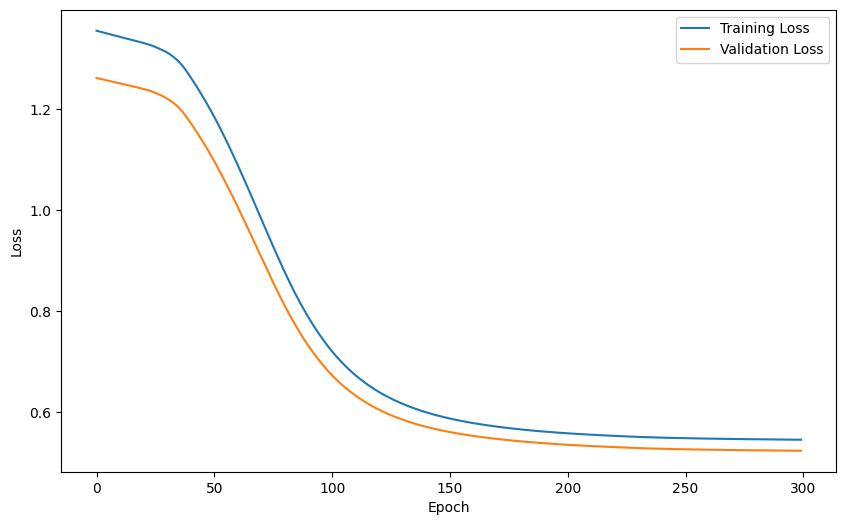

In [106]:
# Train the model
model.train_model(train_loader, val_loader)

In [107]:
# Evaluate the model on the test set and print performance metrics
predictions = model.evaluate_model(X_test_tensor, y_test_tensor)

MAE: 0.514934778213501, MSE: 0.5206220149993896


In [108]:
# Denormalize predictions
predictions_denormalized = scaler.inverse_transform(predictions.detach().numpy())
y_test_denormalized = scaler.inverse_transform(y_test_tensor.numpy())

In [109]:
y_test_denormalized = scaler.inverse_transform(y_test_tensor.numpy())

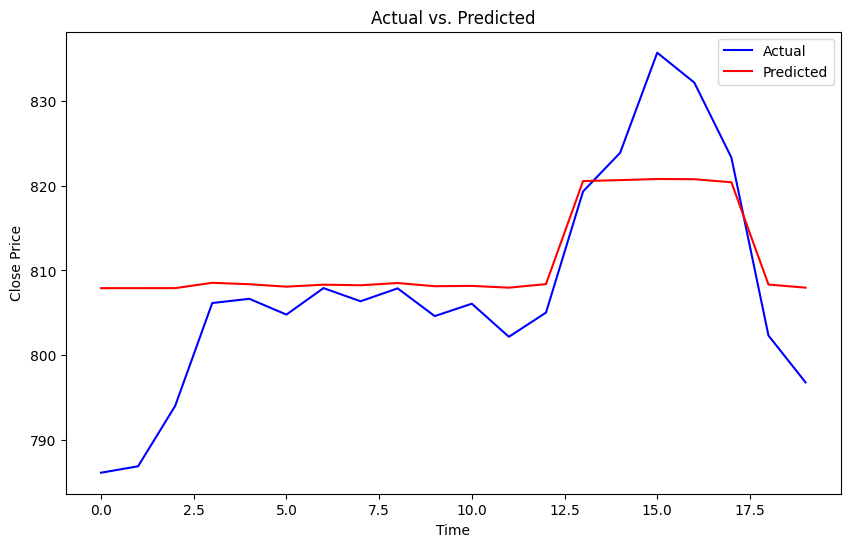

In [110]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))

# Plotting the actual test data
plt.plot(y_test_denormalized, color='blue', label='Actual')

# Plotting the predicted data
plt.plot(predictions_denormalized, color='red', label='Predicted')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()
